### Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pickle
import pandas as pd
import csv
import cv2
import math
import imutils
from collections import Counter

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from mlxtend.classifier import EnsembleVoteClassifier

import joblib
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
from PIL import Image
from skimage.transform import rotate
from skimage import exposure, feature, transform, color
import random
from random import randrange

import scipy
import datetime
import warnings
warnings.filterwarnings('ignore')

train_path = "DataSet/Train"
test_path = "DataSet/Test"
meta_path = "DataSet/Meta"

### load images

1. Read images

In [2]:
# helper functions 
def readTrafficSigns(path, roi):

    images = [] # images
    labels = [] # corresponding labels
    if roi :
        colnames = ['X1','Y1','X2','Y2','Path', 'ClassId']
    else :
        colnames = ['Path', 'ClassId']
    data = pd.read_csv(path+".csv", usecols = colnames)
    lbls = data.ClassId.tolist()
    imgs = data.Path.tolist()
    
    if roi:
        rx1 = data.X1.tolist()
        rx2 = data.X2.tolist()
        ry1 = data.Y1.tolist()
        ry2 = data.Y2.tolist()
        
    print("Image Extracting started !!")
    
    if path == "DataSet/Train":
        train_labels = os.listdir("DataSet/Adds")
        for l in train_labels:
            dir = os.path.join("DataSet/Adds", l)
            imgs_ = os.listdir(dir)
            for img in imgs_:
                file =os.path.join(dir,img)
                im = plt.imread(file)

                im = resize_image(im, 40)
                images.append(im)
                labels.append(l)
    i=0
    for img in imgs:
        im = plt.imread("Dataset/"+img)
        if roi :
            im = im[np.int(ry1[i]):np.int(ry2[i]),
                    np.int(rx1[i]):np.int(rx2[i]),:]
        
        im = resize_image(im, 40)
        images.append(im)
        labels.append(lbls[i])
#        plt.imshow(im)
#        plt.show()
        i+=1
    return images, labels


def format_time(seconds):
    if seconds < 60:
        return f"{int(seconds)} seconds"
    elif seconds < 3600:
        m = seconds // 60
        s = int(seconds % 60)
        return f"{m} minutes {s} seconds"
    else:
        h = seconds // 3600
        m = (seconds % 3600) // 60
        s = int(seconds % 60) 
        return f"{h} hours {m} minutes {s} seconds"

In [3]:
def frequency_plot(y_train):
    
    temp_labels = y_train
    temp_labels = sorted(temp_labels)
    temp_labels = dict(Counter(temp_labels))
    plt.figure(figsize=(8,4))
    plt.bar(range(len(temp_labels)), temp_labels.values(), align='center', color='green',label='Training', alpha=0.3, width=0.7)
    plt.xlabel('Classes')
    plt.ylabel('Distribution')
    plt.title('Frequency Distribution of Class Labels',fontsize=14)
    plt.show()

def resize_image(image, dim):
    resized_image = transform.resize(image, (dim, dim)) 
    return resized_image    

def rotate_image(image, max_angle):
    rotate_out = rotate(image, np.random.uniform(-max_angle, max_angle), mode='edge')
    return rotate_out

In [4]:
def translate_image(image, max_trans = 5, height=40, width=40):
    translate_x = max_trans*np.random.uniform() - max_trans/2
    translate_y = max_trans*np.random.uniform() - max_trans/2
    translation_mat = np.float32([[1,0,translate_x],[0,1,translate_y]])
    trans = cv2.warpAffine(image, translation_mat, (height,width))
    return trans

def image_augmentation(image, temp, max_angle = 15):
    
    #img = noise(image, temp)
    new_img = rotate_image(image, max_angle)
    final_img = translate_image(new_img)
    
    return final_img

In [5]:
def data_augmentation(X_train, y_train, batch_size=30,  dim=40):
    if os.path.isfile("Aug_images.npy") &  os.path.isfile("Aug_labels.npy") :
        X_train = np.load("Aug_images.npy" )
        y_train = np.load("Aug_labels.npy" )
        print("[INFO] Aug_images and Aug_labels are loaded in variables ==> X, y")
        print("[INFO] Number of Aug_images {} \nNumber of Labels {}".format(len(X_train), len(y_train)))
    else:
 
        temp_labels = y_train
        temp_labels = dict(Counter(temp_labels))
        temp_labels = sorted(temp_labels.items(), key=lambda kv: kv[1])
        limit = temp_labels[len(temp_labels)-1][1]
        train_x = X_train
        train_y = y_train
    
        for x in temp_labels:
            y = x[0]
            count_y = x[1]
            indices = np.argwhere(train_y==y).flatten()
            print(y, count_y)
            while count_y < limit:
                lst_x = []
                lst_y = []
                index = randrange(batch_size, len(indices), batch_size)
    
                for i in range(index - 1, (index - batch_size) - 1, -1):
                    temp = random.randint(14, 25)
                    to_augment = np.asarray(train_x[indices[i]]).reshape(dim, dim, 3)
                    lst_x.append(image_augmentation(to_augment, temp))
                    lst_y.append(train_y[indices[i]])
    
                count_y += 30
#                X_train.extend(lst_x)
                X_train = np.append(X_train, lst_x, axis=0)
                y_train = np.append(y_train, lst_y, axis=0)
#                y_train.extend(lst_y)
        np.save("Aug_images.npy", X_train)
        np.save("Aug_labels.npy", y_train)
        print("[INFO] Aug_images and Aug_labels are read from the dataset directory")
        print("[INFO] Aug_images saved to Aug_images.npy for further use")
        print("[INFO] Aug_labels saved to Aug_labels.npy for further use")
        X_train = np.load("Aug_images.npy", allow_pickle=True)
        y_train = np.load("Aug_labels.npy", allow_pickle=True)
        print("[INFO] Aug_images and Aug_labels are loaded in variables ==> X, y")
        print("[INFO] Number of Aug_images {} \nNumber of Labels {}".format(len(X_train), len(y_train)))
    
    frequency_plot(y_train)
    
    return X_train, y_train

2. load training images

In [6]:
if os.path.isfile("trainImages.npy") &  os.path.isfile("trainLabels.npy") :
    X_train = np.load("trainImages.npy", allow_pickle=True)
    y_train = np.load("trainLabels.npy", allow_pickle=True)
    print("[INFO] Training images and labels are loaded in variables ==> X,y")
    print("[INFO] Number of training Images {} \nNumber of Labels {}".format(len(X_train), len(y_train)))
else:    
    # training images and labels
    trainImages, trainLabels = readTrafficSigns(train_path, True)
    np.save("trainImages.npy",trainImages)
    np.save("trainLabels.npy",trainLabels)
    print("[INFO] training images and labels are read from the dataset directory")
    print("[INFO] training images saved to trainingImages.npy for further use")
    print("[INFO] training labels saved to trainingLabels.npy for further use")
    X_train = np.load("trainImages.npy", allow_pickle=True)
    y_train = np.load("trainLabels.npy", allow_pickle=True)
    print("[INFO] Training images and labels are loaded in variables ==> X_train,y_train")
    print("[INFO] Number of training Images {} \nNumber of Labels {}".format(len(X_train), len(y_train)))

[INFO] Training images and labels are loaded in variables ==> X,y
[INFO] Number of training Images 39628 
Number of Labels 39628


3. load testing images

In [7]:
if os.path.isfile("testImages.npy") &  os.path.isfile("testLabels.npy") :
    X_test = np.load("testImages.npy", allow_pickle=True)
    y_test = np.load("testLabels.npy", allow_pickle=True)
    print("[INFO] Testing images and labels are loaded in variables ==> X_test,y_test")
    print("[INFO] Number of testing Images {} \nNumber of Labels {}".format(len(X_test), len(y_test)))
else:    
    # testing images and labels
    testImages, testLabels = readTrafficSigns(test_path, True)
    np.save("testImages.npy",testImages)
    np.save("testLabels.npy",testLabels)
    print("[INFO] testing images and labels are read from the dataset directory")
    print("[INFO] testing images saved to testingImages.npy for further use")
    print("[INFO] testning labels saved to testingLabels.npy for further use")
    X_test = np.load("testImages.npy", allow_pickle=True)
    y_test = np.load("testLabels.npy", allow_pickle=True)
    print("[INFO] Testing images and labels are loaded in variables ==> X_test,y_test")
    print("[INFO] Number of testing Images {} \nNumber of Labels {}".format(len(X_test), len(y_test)))

[INFO] Testing images and labels are loaded in variables ==> X_test,y_test
[INFO] Number of testing Images 12630 
Number of Labels 12630


4. load meta images

In [8]:
if os.path.isfile("metaImages.npy") &  os.path.isfile("metaLabels.npy") :
    X_meta = np.load("metaImages.npy", allow_pickle=True)
    y_meta = np.load("metaLabels.npy", allow_pickle=True)
    print("[INFO] Meta images and labels are loaded in variables ==> X_meta,y_meta")
    print("[INFO] Number of Meta Images {} \nNumber of Labels {}".format(len(X_meta), len(y_meta)))
else:    
    # testing images and labels
    metaImages, metaLabels = readTrafficSigns(meta_path, False)
    np.save("metaImages.npy",metaImages)
    np.save("metaLabels.npy",metaLabels)
    print("[INFO] meta images and labels are read from the dataset directory")
    print("[INFO] meta images saved to metaImages.npy for further use")
    print("[INFO] meta labels saved to metaLabels.npy for further use")
    X_meta = np.load("metaImages.npy", allow_pickle=True)
    y_meta = np.load("metaLabels.npy", allow_pickle=True)
    print("[INFO] meta images and labels are loaded in variables ==> X_meta,y_meta")
    print("[INFO] Number of meta Images {} \nNumber of Labels {}".format(len(X_meta), len(y_meta)))

[INFO] Meta images and labels are loaded in variables ==> X_meta,y_meta
[INFO] Number of Meta Images 43 
Number of Labels 43


###  Augmentation data

[INFO] Aug_images and Aug_labels are loaded in variables ==> X, y
[INFO] Number of Aug_images 97168 
Number of Labels 97168


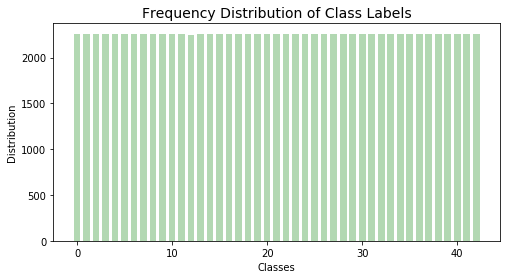

In [9]:
X_train, y_train = data_augmentation(X_train, y_train)

In [10]:
X_train.shape, y_train.shape

((97168, 40, 40, 3), (97168,))

###  Features extraction

Cartesian to log-polar

In [11]:
def cart_to_log_polar(img,T):
    img = img.astype(np.float32)
    h, w = img.shape[:2]
    maxRadius = math.hypot(w/2,h/2)
    m = w / math.log(maxRadius)
    polar_img = cv2.logPolar(img,(w/2, h/2), m/T, cv2.WARP_FILL_OUTLIERS+ cv2.INTER_LINEAR)
    return polar_img

#### 1. Histogram of Oriented Gradients (HOG)

In [12]:
def extract_HOG(img):
    (H, hog_img) = feature.hog(img, orientations=9, pixels_per_cell=(5,5),
    cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
    hog_img = exposure.rescale_intensity(hog_img, out_range=(0, 255)).astype("uint8")
    return H,hog_img   

#### 2. Local Binary Pattern (LBP)

In [13]:
def extract_LBP(img):
    rows, cols = img.shape
    radius = 2
    n_points = radius * 8
    lbp_sum=[]
    rows_ = rows+(6-rows%6)
    cols_ = cols+(6-cols%6)
    I1 = np.zeros((rows_,cols_))
    I1[0:rows,0:cols] = img
    for i in range(6):
        for j in range(6):
            img_block = I1[7*i:7*(i+1),7*j:7*(j+1)]
            lbp = feature.local_binary_pattern(img_block, n_points, radius, 'uniform')
            lbp2 = lbp.astype(np.int32)
            max_bins = 59
            train_hist, _ = np.histogram(lbp2.ravel(), normed=True, bins=max_bins, range=(0, max_bins))
            lbp_sum=lbp_sum + train_hist.tolist()
    lbp_sum = np.array(lbp_sum)          
    return lbp_sum

### Prepare train & test data

#### 1. Train features extraction

In [14]:
if os.path.isfile("TrainFeatures.npy"):
    print("[INFO] loading from file ... ")
    train_feat = np.load("TrainFeatures.npy")
    print("Train features are loaded from TrainFeatures.npy to variable ==> train_feat")
else:
    print("[INFO] TrainFeatures.npy does not found")
    start_time = datetime.datetime.now()
    train_feat = []
    for i in range(0,len(X_train)):
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(X_train)))
        I = X_train[i]
        grayim = color.rgb2gray(I)
        #grayim = resize_image(grayim,(40,40))
        grayim = cart_to_log_polar(grayim,0.8)
        (H_4x4, hogImage) = extract_HOG(grayim)
        lbp = extract_LBP(grayim)
        features = np.hstack([H_4x4,lbp])
        train_feat.append(features)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("TrainFeatures.npy", train_feat)
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] TrainFeatures.npy are saved")
    print("total_time",t)
    print("[INFO] loading from file ... ")
    train_feat = np.load("TrainFeatures.npy")
    print("Train features are loaded from TrainFeatures.npy to variable ==> train_feat")

[INFO] loading from file ... 
Train features are loaded from TrainFeatures.npy to variable ==> train_feat


#### 2  Test features extraction

In [15]:
if os.path.isfile("TestFeatures.npy"):
    print("[INFO] loading from file ... ")
    test_feat = np.load("TestFeatures.npy")
    print("Test features are loaded from TestFeatures.npy to variable ==> test_feat")
else:
    print("[INFO] TestFeatures.npy does not found")
    start_time = datetime.datetime.now()
    test_feat = []
    for i in range(0,len(X_test)):
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(X_test)))
        I = X_test[i]
        grayim = color.rgb2gray(I)
        grayim = transform.resize(grayim,(40,40))
        grayim = cart_to_log_polar(grayim,0.8)
        (H_4x4, hogImage) = extract_HOG(grayim)
        lbp = extract_LBP(grayim)
        features = np.hstack([H_4x4,lbp])
        test_feat.append(features)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("TestFeatures.npy", test_feat)
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] TestFeatures.npy are saved")
    print("total_time",t)
    print("[INFO] loading from file ... ")
    test_feat = np.load("TestFeatures.npy")
    print("Test features are loaded from TestFeatures.npy to variable ==> test_feat")

[INFO] loading from file ... 
Test features are loaded from TestFeatures.npy to variable ==> test_feat


#### 3. Meta features extraction

In [16]:
if os.path.isfile("MetaFeatures.npy"):
    print("[INFO] loading from file ... ")
    meta_feat = np.load("MetaFeatures.npy")
    print("Meta features are loaded from MetaFeatures.npy to variable ==> meta_feat")
else:
    print("[INFO] MetaFeatures.npy does not found")
    start_time = datetime.datetime.now()
    meta_feat = []
    for i in range(0,len(X_meta)):
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(X_meta)))
        I = X_meta[i]
        grayim = color.rgb2gray(I)
        grayim = transform.resize(grayim,(40,40))
        grayim = cart_to_log_polar(grayim,0.8)
        (H_4x4, hogImage) = extract_HOG(grayim)
        lbp = extract_LBP(grayim)
        features = np.hstack([H_4x4,lbp])
        meta_feat.append(features)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("MetaFeatures.npy", meta_feat)
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] MetaFeatures.npy are saved")
    print("total_time",t)
    print("[INFO] loading from file ... ")
    meta_feat = np.load("MetaFeatures.npy")
    print("Meta features are loaded from MetaFeatures.npy to variable ==> meta_feat")

[INFO] loading from file ... 
Meta features are loaded from MetaFeatures.npy to variable ==> meta_feat


#### 4. Data type conversion

In [17]:
X_train = np.array(train_feat).astype("float")
y_train = y_train.astype("float")
print(X_train.shape,y_train.shape)
print(np.unique(y_train))

(97168, 3888) (97168,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42.]


In [18]:
X_test = np.array(test_feat).astype("float")
y_test = y_test.astype("float")
print(X_test.shape, y_test.shape)
print(np.unique(y_test))

(12630, 3888) (12630,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42.]


In [19]:
X_meta = np.array(meta_feat).astype("float")
y_meta = y_meta.astype("float")
print(X_meta.shape, y_meta.shape)
print(np.unique(y_meta))

(43, 3888) (43,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42.]


### Training classifiers

#### 1. SVM

In [23]:
if os.path.isfile("clf_svc.pkl.gz"):
    print("[INFO] loading classifier: SVC trained on Combine features...")
    svc = joblib.load("clf_svc.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::svc::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier SVC")
    start_time = datetime.datetime.now()
    svc = SVC(C=7.0, kernel='rbf',gamma=0.09)
    svc.fit(X_train, y_train)
    print("[INFO] Succefully trained the Combine classsifier. \n Saving the classifier for further use")
    joblib.dump(svc, 'clf_svc.pkl.gz', compress=('gzip', 3))
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: SVC trained on Combine features...")
    svc = joblib.load("clf_svc.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::svc::")

[INFO] loading classifier: SVC trained on Combine features...
[INFO] Classifer is loaded as instance ::svc::


#### 2. Multi-layer perceptron

In [24]:
# MLP
if os.path.isfile("clf_mlp.pkl.gz"):
    print("[INFO] loading classifier: MLP trained on Combine features...")
    mlp = joblib.load("clf_mlp.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::mlp::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \MLP")
    start_time = datetime.datetime.now()
    mlp = MLPClassifier(hidden_layer_sizes=(700,))
    mlp.fit(X_train, y_train)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(mlp, 'clf_mlp.pkl.gz', compress=('gzip', 3)) 
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: MLP trained on combined features...")
    mlp = joblib.load("clf_mlp.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::mlp::")

[INFO] loading classifier: MLP trained on Combine features...
[INFO] Classifer is loaded as instance ::mlp::


#### 3. Random forest

In [25]:
# RF
if os.path.isfile("clf_rf.pkl.gz"):
    print("[INFO] loading classifier: RF trained on Combine features...")
    rf = joblib.load("clf_rf.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::rf::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \RF")
    start_time = datetime.datetime.now()
    rf = RandomForestClassifier(n_jobs = -1, n_estimators = 200, criterion='entropy', max_depth=None)
    rf.fit(X_train, y_train)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(rf, 'clf_rf.pkl.gz', compress=('gzip', 3)) 
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: RF trained on Conbined features...")
    rf = joblib.load("clf_rf.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::rf::")

[INFO] loading classifier: RF trained on Combine features...
[INFO] Classifer is loaded as instance ::rf::


#### 4. Stochastic Gradient Descent

In [26]:
# SGD
if os.path.isfile("clf_sgd.pkl.gz"):
    print("[INFO] loading classifier: SGD trained on Combine features...")
    sgd = joblib.load("clf_sgd.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::sgd::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \SGD")
    start_time = datetime.datetime.now()
    sgd = SGDClassifier(n_jobs = -1 ,tol=1e-5)
    sgd.fit(X_train, y_train)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(sgd, 'clf_sgd.pkl.gz', compress=('gzip', 3))
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: SGD trained on Conbined features...")
    sgd = joblib.load("clf_sgd.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::sgd::")

[INFO] loading classifier: SGD trained on Combine features...
[INFO] Classifer is loaded as instance ::sgd::


#### 5. K Nearest Neighbors

In [22]:
# KNN
if os.path.isfile("clf_knn.pkl.gz"):
    print("[INFO] loading classifier: KNN trained on Combine features...")
    knn = joblib.load("clf_knn.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::knn::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \KNN")
    start_time = datetime.datetime.now()
    knn = KNeighborsClassifier(n_neighbors = 1, n_jobs = -1)
    knn.fit(X_train, y_train)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(knn, 'clf_knn.pkl.gz', compress=('gzip', 3)) 
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: KNN trained on Conbined features...")
    knn = joblib.load("clf_knn.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::knn::")

[INFO] loading classifier: KNN trained on Combine features...
[INFO] Classifer is loaded as instance ::knn::


#### 6. AdaBoost

In [31]:
# ADB
if os.path.isfile("clf_adb.pkl.gz"):
    print("[INFO] loading classifier: ADB trained on Combine features...")
    adb = joblib.load("clf_adb.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::adb::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \ADB")
    start_time = datetime.datetime.now()
    adb = AdaBoostClassifier(n_estimators=200)
    adb.fit(X_train, y_train)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(adb, 'clf_adb.pkl.gz', compress=('gzip', 3)) 
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: ADB trained on Conbined features...")
    adb = joblib.load("clf_adb.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::adb::")

[INFO] loading classifier: ADB trained on Combine features...
[INFO] Classifer is loaded as instance ::adb::


#### 7. Decision Tree

In [32]:
# Tree
if os.path.isfile("clf_tree.pkl.gz"):
    print("[INFO] loading classifier: Tree trained on Combine features...")
    tree = joblib.load("clf_tree.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::tree::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \Tree")
    start_time = datetime.datetime.now()
    tree =  DecisionTreeClassifier(criterion = "gini", random_state = 100)
    tree.fit(X_train, y_train)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(tree, 'clf_tree.pkl.gz', compress=('gzip', 3)) 
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: Tree trained on Conbined features...")
    tree = joblib.load("clf_tree.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::tree::")

[INFO] loading classifier: Tree trained on Combine features...
[INFO] Classifer is loaded as instance ::tree::


#### 8. GaussianNB

In [28]:
# GNB

if os.path.isfile("clf_gnb.pkl.gz"):
    print("[INFO] loading classifier: GNB trained on Combine features...")
    gnb = joblib.load("clf_gnb.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::GNB::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \GNB")
    start_time = datetime.datetime.now()
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(gnb, 'clf_gnb.pkl.gz', compress=('gzip', 3))
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: GNB trained on Conbined features...")
    gnb = joblib.load("clf_gnb.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::gnb::")

[INFO] loading classifier: GNB trained on Combine features...
[INFO] Classifer is loaded as instance ::GNB::


#### 9. Quadratic Discriminant Analysis

In [25]:
# QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
if os.path.isfile("clf_qda.pkl.gz"):
    print("[INFO] loading classifier: QDA trained on Combine features...")
    qda = joblib.load("clf_qda.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::QDA::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \QDA")
    start_time = datetime.datetime.now()
    qda =  LinearDiscriminantAnalysis()
    qda.fit(X_train, y_train)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(qda, 'clf_qda.pkl.gz', compress=('gzip', 3))
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: QDA trained on Conbined features...")
    qda = joblib.load("clf_qda.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::qda::")

[INFO] loading classifier: QDA trained on Combine features...
[INFO] Classifer is loaded as instance ::QDA::


#### 10. Logistic Regression

In [27]:
# LCR
if os.path.isfile("clf_lcr.pkl.gz"):
    print("[INFO] loading classifier: LCR trained on Combined features...")
    lcr = joblib.load("clf_lcr.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::LCR::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \LCR")
    start_time = datetime.datetime.now()
    lcr =  LogisticRegression()
    lcr.fit(X_train, y_train)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(lcr, 'clf_lcr.pkl.gz', compress=('gzip', 3))
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: LCR trained on Conbined features...")
    lcr = joblib.load("clf_lcr.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::lcr::")

[INFO] loading classifier: LCR trained on Combined features...
[INFO] Classifer is loaded as instance ::LCR::


#### 11. Extra Trees

In [ ]:
# EX_Tree
if os.path.isfile("clf_exTree.pkl.gz"):
    print("[INFO] loading classifier: ExTree trained on Combined features...")
    exTree = joblib.load("clf_exTree.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::exTree::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \exTree")
    start_time = datetime.datetime.now()
    exTree =  ExtraTreesClassifier(n_estimators=200, n_jobs=-1)
    exTree.fit(X_train, y_train)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(exTree, 'clf_exTree.pkl.gz', compress=('gzip', 3))
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: exTree trained on Conbined features...")
    exTree = joblib.load("clf_exTree.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::exTree::")

[INFO] loading classifier: ExTree trained on Combined features...


#### ==> Ensemble

In [20]:
# Ensemble
if os.path.isfile("model1.pkl.gz"):
    print("[INFO] loading classifier: Ensemble trained on Combined features...")
    model = joblib.load("model1.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::model::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier \Ensemble")
    start_time = datetime.datetime.now()
    estimators = [svc, mlp, rf, lcr, sgd]
    weights = [0.2, 0.3, 0.2, 0.2, 0.1]
    model =  EnsembleVoteClassifier(clfs=estimators, voting="hard", weights= weights, refit=False)
    model.fit(None, np.unique(y_train))
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(model, 'model1.pkl.gz', compress=('gzip', 3))
    end_time = datetime.datetime.now()
    dt = end_time - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("[INFO] Classifier Saved")
    print("total_time",t)
    print("[INFO] loading classifier: Ensemble trained on Conbined features...")
    #model = joblib.load("model1.pkl.gz")
    print("[INFO] Classifer is loaded as instance ::model::")

[INFO] loading classifier: Ensemble trained on Combined features...
[INFO] Classifer is loaded as instance ::model::


### Classifiers performance analysis

#### 1. SVM

In [33]:
print("accuracy on training data: {}".format(svc.score(X_train, y_train)))

accuracy on training data: 1.0


In [27]:
print("accuracy on test data: {}".format(svc.score(X_test, y_test)))

accuracy on test data: 0.9280285035629454


In [28]:
print("accuracy on validation data: {}".format(svc.score(X_meta, y_meta)))

accuracy on validation data: 0.8604651162790697


#### 2. MLP

In [22]:
print("accuracy on training data: {}".format(mlp.score(X_train, y_train)))

accuracy on training data: 1.0


In [23]:
print("accuracy on test data: {}".format(mlp.score(X_test, y_test)))

accuracy on test data: 0.9528899445764054


In [24]:
print("accuracy on validation data: {}".format(mlp.score(X_meta, y_meta)))

accuracy on validation data: 0.8604651162790697


#### 3. RF

In [67]:
print("accuracy on training data: {}".format(rf.score(X_train, y_train)))

accuracy on training data: 1.0


In [68]:
print("accuracy on test data: {}".format(rf.score(X_test, y_test)))

accuracy on test data: 0.9315122723673792


In [69]:
print("accuracy on validation data: {}".format(rf.score(X_meta, y_meta)))

accuracy on validation data: 0.813953488372093


#### 4. SGD

In [70]:
print("accuracy on training data: {}".format(sgd.score(X_train, y_train)))

accuracy on training data: 0.9659558702453482


In [71]:
print("accuracy on test data: {}".format(sgd.score(X_test, y_test)))

accuracy on test data: 0.9359461599366588


In [72]:
print("accuracy on validation data: {}".format(sgd.score(X_meta, y_meta)))

accuracy on validation data: 0.7674418604651163


#### 5. KNN

In [87]:
print("accuracy on training data: {}".format(knn.score(X_train, y_train)))

accuracy on training data: 0.9749506010209122


In [34]:
print("accuracy on test data: {}".format(knn.score(X_test, y_test)))

accuracy on test data: 0.907680126682502


In [23]:
print("accuracy on validation data: {}".format(knn.score(X_meta, y_meta)))

accuracy on validation data: 0.7906976744186046


#### 6. ADB

In [73]:
print("accuracy on training data: {}".format(adb.score(X_train, y_train)))

accuracy on training data: 0.2358389593281739


In [74]:
print("accuracy on test data: {}".format(adb.score(X_test, y_test)))

accuracy on test data: 0.27149643705463183


In [75]:
print("accuracy on validation data: {}".format(adb.score(X_meta, y_meta)))

accuracy on validation data: 0.20930232558139536


#### 7. Tree

In [90]:
print("accuracy on training data: {}".format(tree.score(X_train, y_train)))

accuracy on training data: 1.0


In [91]:
print("accuracy on test data: {}".format(tree.score(X_test, y_test)))

accuracy on test data: 0.7212193190815519


In [92]:
print("accuracy on validation data: {}".format(tree.score(X_meta, y_meta)))

accuracy on validation data: 0.5581395348837209


#### 8. GNB

In [76]:
print("accuracy on training data: {}".format(gnb.score(X_train, y_train)))

accuracy on training data: 0.7503910752511115


In [77]:
print("accuracy on test data: {}".format(gnb.score(X_test, y_test)))

accuracy on test data: 0.7532858273950911


In [29]:
print("accuracy on validation data: {}".format(gnb.score(X_meta, y_meta)))

accuracy on validation data: 0.5348837209302325


#### 9. QDA

In [79]:
print("accuracy on training data: {}".format(qda.score(X_train, y_train)))

accuracy on training data: 1.0


In [80]:
print("accuracy on test data: {}".format(qda.score(X_test, y_test)))

accuracy on test data: 0.06381631037212986


In [81]:
print("accuracy on validation data: {}".format(qda.score(X_meta, y_meta)))

accuracy on validation data: 0.023255813953488372


#### 10. LCR

In [82]:
print("accuracy on training data: {}".format(lcr.score(X_train, y_train)))

accuracy on training data: 0.9860344969537296


In [83]:
print("accuracy on test data: {}".format(lcr.score(X_test, y_test)))

accuracy on test data: 0.9316706254948536


In [84]:
print("accuracy on validation data: {}".format(lcr.score(X_meta, y_meta)))

accuracy on validation data: 0.7906976744186046


#### 11. ExTree

In [23]:
print("accuracy on training data: {}".format(exTree.score(X_train, y_train)))

accuracy on training data: 1.0


In [22]:
print("accuracy on test data: {}".format(exTree.score(X_test, y_test)))

accuracy on test data: 0.9353127474267616


In [21]:
print("accuracy on validation data: {}".format(exTree.score(X_meta, y_meta)))

accuracy on validation data: 0.8604651162790697


#### ==> Ensemble

In [ ]:
print("accuracy on training data: {}".format(model.score(X_train, y_train)))

In [29]:
print("accuracy on test data: {}".format(model.score(X_test, y_test)))

accuracy on test data: 0.953840063341251


In [31]:
print("accuracy on validation data: {}".format(model.score(X_meta, y_meta)))

accuracy on validation data: 0.8837209302325582


In [25]:
from sklearn.metrics import f1_score, accuracy_score
#y_pred = model.predict(X_test).tolist()
#y_pred = joblib.dump(y_pred, "predictions_test.npy")
y_pred = joblib.load("predictions_test.npy")
accuracy_score(y_test, y_pred) * 100
f1_score(y_test, y_pred, average='micro')

0.9523357086302454

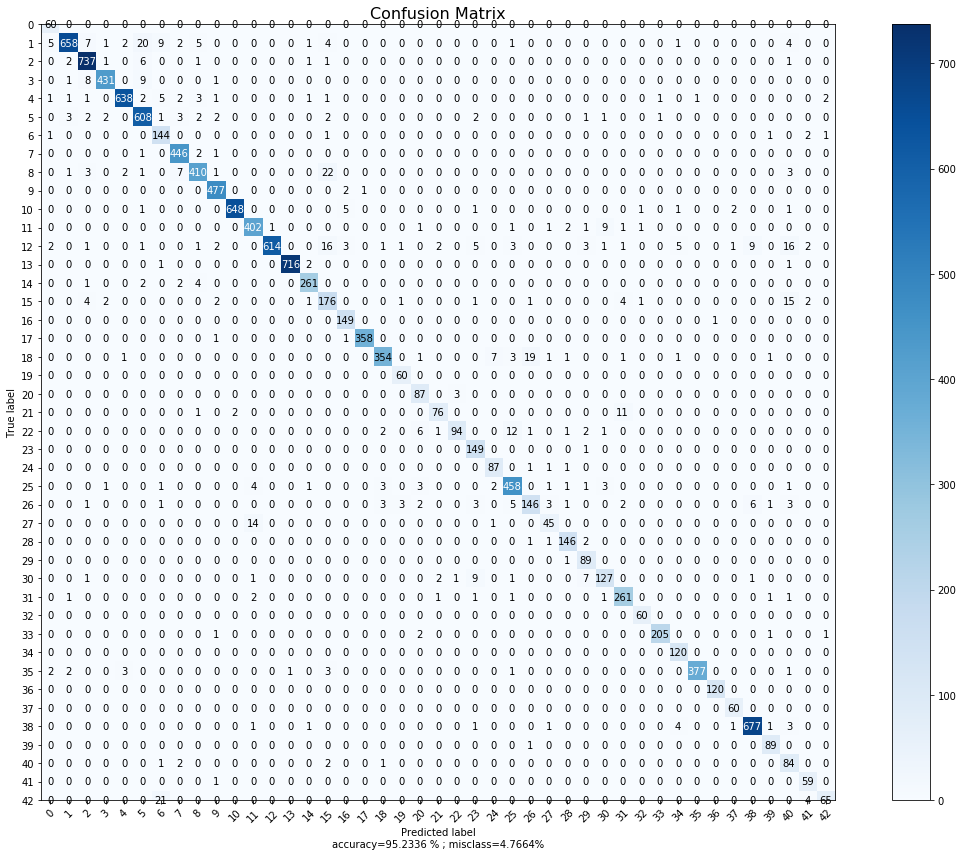

In [25]:
import scikitplot as skplt
from sklearn.metrics import accuracy_score
#y_pred = model.predict(X_test).tolist()
accuracy = accuracy_score(y_test, y_pred) * 100
misclass = 100 - accuracy
y_pred = joblib.load("predictions_test.npy")
skplt.metrics.plot_confusion_matrix(y_test.astype(int), np.array(y_pred).astype(int), x_tick_rotation=45,figsize=((16,12)),
                                    cmap = plt.get_cmap('Blues'), normalize=False, title_fontsize=16, text_fontsize=10, hide_zeros=False)

plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f} % ; misclass={:0.4f}%'.format(accuracy, misclass))
plt.tight_layout()
plt.savefig('Confusion Matrix test.png')
plt.show()

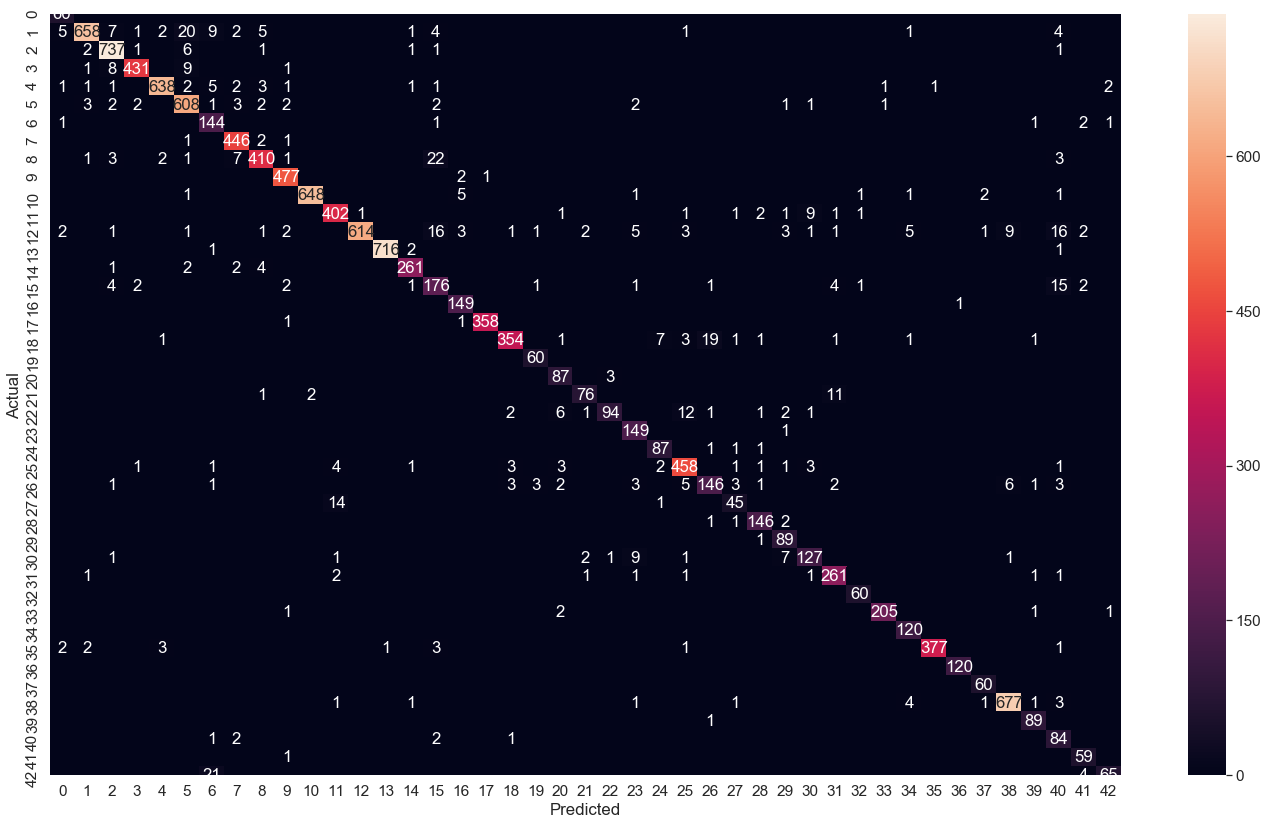

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%d' % (c)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%d' % (c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig('Confusion_Matrix.png')

y_pred = joblib.load("predictions_test.npy")
#cm = confusion_matrix(y_test, y_pred)
cm_analysis(y_test, y_pred, range(43), ymap=None, figsize=(24,14))